In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
from fastai import *
from fastai.vision import *
from fastai.layers import *
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

In [4]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=2) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    samples = [s for s in samples if s[1].data[0].shape[0] > 0] # check that labels are available

    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        bboxes[i,-len(lbls):] = bbs
        labels[i,-len(lbls):] = lbls
    return torch.cat(imgs,0), (bboxes,labels)

In [5]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [6]:
images, lbl_bbox = get_annotations(path/'WhiteBloodCellCoco.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [ ]:
class BloodCellObjectCategoryProcessor(ObjectCategoryProcessor):                 
                                                                                 
    def generate_classes(self, items):                                           
        "Generate classes from `items` by taking the sorted unique values."      
        classes = set()                                                          
        for c in items: classes = classes.union(set(c[1]))                       
        classes = list(classes)                                                  
        classes.sort()                                                           
        return classes                                                           

In [51]:
class BloodCellObjectCategoryList(ObjectCategoryList):
     _processor = BloodCellObjectCategoryProcessor  
    
    def analyze_pred(self, pred):
        return [pred[0], pred[1].max(0)[1]]
    
    def reconstruct(self, t, x):
        (bboxes, labels) = t
        #if len((labels - self.pad_idx).nonzero()) == 0: return
        if labels.ndim == 0: labels = labels.view(-1)
        i = 0
        bboxes,labels = bboxes[i:],labels[i:]
        return ImageBBox.create(*x.size, bboxes, labels=labels, classes=self.classes, scale=False)

In [52]:
data = (ObjectItemList.from_folder(path, extensions='.bmp')
        #Where are the images? -> in coco
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func, label_cls=BloodCellObjectCategoryList)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=256)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate

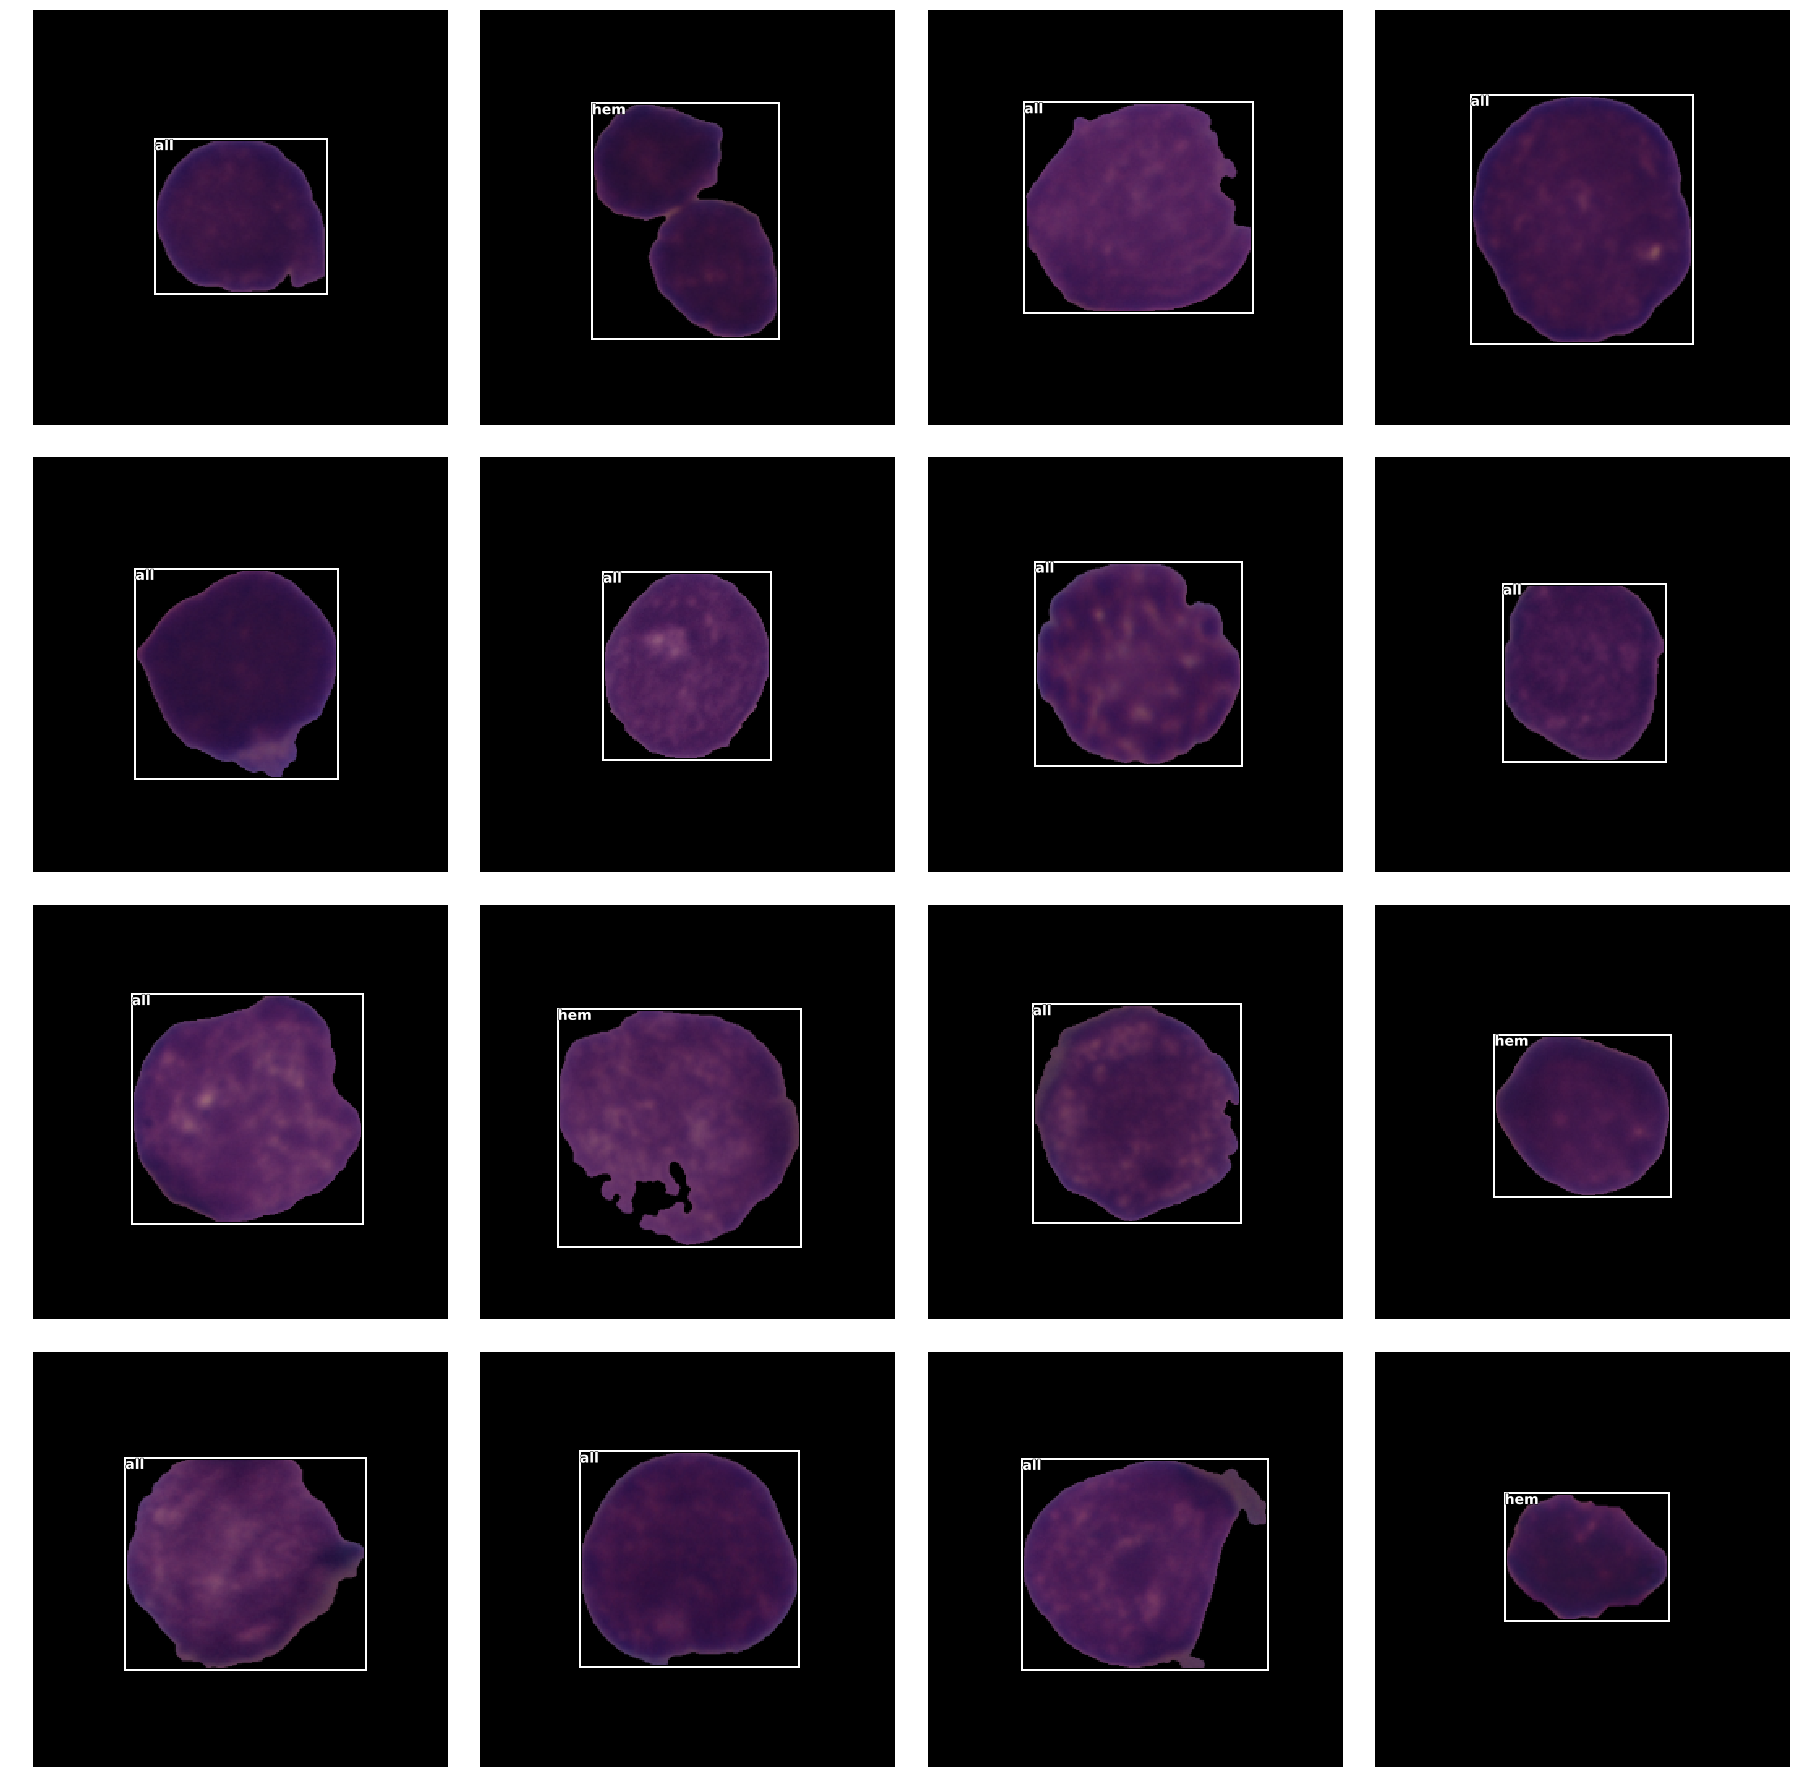

In [8]:
data.show_batch(rows=4, ds_type=DatasetType.Valid, figsize=(25,25))

In [53]:
class CellFinder(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__()
        self.cnn = create_body(arch)
        self.box_regressor = create_head(num_features_model(self.cnn) * 2, 4)
        self.classifier = create_head(num_features_model(self.cnn) * 2, 2)

    def forward(self, im):
        x = self.cnn(im)
        box = self.box_regressor(x)
        classifier = self.classifier(x)

        return [(2 * (box.sigmoid_() - 0.5)).view(-1, 1, 4), classifier]

In [54]:
class CombinedLoss(nn.Module):

    def forward(self, output, bbox_tgts, clas_tgts):
        bbox_preds, clas_preds = output

        self.loss1 = L1Loss()(bbox_preds, bbox_tgts.squeeze())
        self.loss2 = CrossEntropyFlat()(clas_preds, clas_tgts)
        return self.loss1 + self.loss2

In [55]:
class HandleDualLoss(LearnerCallback):
    _order = -20 #Needs to run before the recorder
    
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['bb_loss', 'c_loss'])
    
    def on_epoch_begin(self, **kwargs):
        self.bb_loss, self.c_loss, self.nums = 0., 0., 0
    
    def on_batch_end(self, last_target, train, **kwargs):
        if not train:
            bs = last_target[0].size(0)
            self.bb_loss += bs * learn.loss_func.loss1.detach()
            self.c_loss += bs * learn.loss_func.loss2.detach()
            self.nums += bs
    
    def on_epoch_end(self, **kwargs):
        self.learn.recorder.add_metrics([self.bb_loss/self.nums, self.c_loss/self.nums])

In [56]:
def loss_fn(output, bbox_tgts, clas_tgts):
    clas_preds, bbox_preds = output
    return L1Loss()(bbox_preds, bbox_tgts.squeeze()) \
           + CrossEntropyFlat()(clas_preds, clas_tgts-1)

In [57]:
def iou_metric(output, bbox_tgts, clas_tgts):
    clas_preds, bbox_preds = output
    return dice(bbox_tgts.squeeze(), bbox_preds.long()).item()

In [58]:
learn = Learner(data, CellFinder(arch=models.resnet18), loss_func=CombinedLoss(), callback_fns=[HandleDualLoss])
#learn.metrics = [iou_metric]

learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.box_regressor, learn.model.classifier])

In [59]:
learn.freeze_to(-2)

In [60]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,bb_loss,c_loss
1,0.592060,0.707404,0.078908,0.628495
2,0.515342,0.407507,0.072123,0.335385
3,0.453294,0.437005,0.066791,0.370214
4,0.420794,0.361552,0.077074,0.284478
5,0.371134,0.343504,0.077198,0.266306


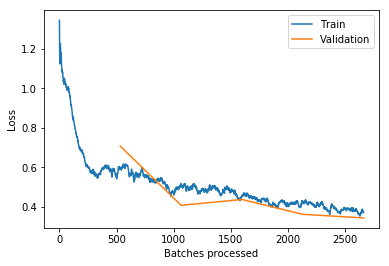

In [61]:
learn.recorder.plot_losses()

In [35]:
learn.unfreeze()

In [38]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr, max_lr]

In [39]:
learn.fit_one_cycle(10, lrs, div_factor=20)

epoch,train_loss,valid_loss,bb_loss,c_loss
1,0.312384,0.259448,0.030036,0.229413
2,0.307969,0.344600,0.034537,0.310063
3,0.314404,0.311748,0.035568,0.276180
4,0.308129,0.416045,0.032326,0.383719
5,0.311426,0.272675,0.043915,0.228760
6,0.284566,0.246244,0.031225,0.215018
7,0.300603,0.253669,0.034760,0.218908
8,0.266199,0.232656,0.033124,0.199532
9,0.259432,0.239186,0.037091,0.202095
10,0.263146,0.229955,0.035186,0.194769


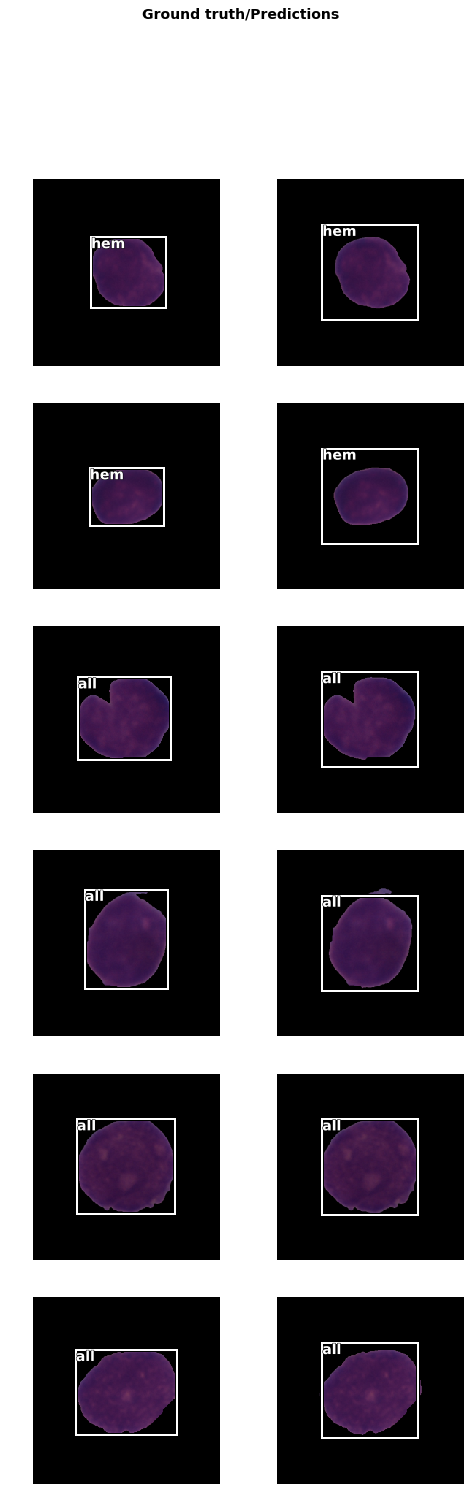

In [65]:
learn.show_results(rows=6)